In [13]:
from data import AudioDataset
from model import CRNN
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt

# create a new instance of the AudioDataset class for the test set
warblrb10k = AudioDataset(csv_file="../data/warblrb10k_public_metadata.csv", audio_dir="../data/warblrb10k_public/wav/")
ff1010 = AudioDataset(csv_file="../data/ff1010bird_metadata.csv", audio_dir="../data/ff1010bird/wav/")
birdvox = AudioDataset(csv_file="../data/BirdVoxDCASE20k_csvpublic.csv", audio_dir="../data/BirdVox-DCASE-20k/wav")

test_dataset = ConcatDataset([warblrb10k, ff1010, birdvox])

# create a DataLoader object to iterate over the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [14]:
# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN().to(device)
model.load_state_dict(torch.load("best_model.pt"))

# Evaluate the model on the validation set
model.eval()
val_preds = []
val_targets = []

print("Evaluating...")
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.round()
        val_preds.extend(preds.cpu().numpy())
        val_targets.extend(labels.cpu().numpy())
print("Evaluating done!")


Evaluating...


100%|██████████| 1116/1116 [19:23<00:00,  1.04s/it]

Evaluating done!


In [15]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

print(f"AUC: {roc_auc_score(val_targets, val_preds):.4f}")
print(f"Acc: {accuracy_score(val_targets, val_preds):.4f}")
print(f"F1: {f1_score(val_targets, val_preds):.4f}")


=> Val AUC: 0.8372


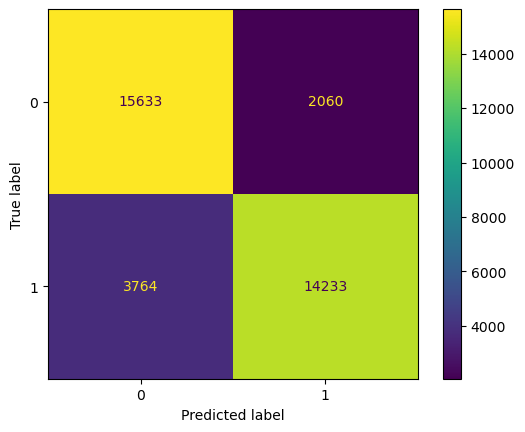

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(val_targets, val_preds)

cm_display = ConfusionMatrixDisplay(cm).plot()


## Résultats

~30% des données en train, validation sur la totalité :

|     | freefield | warbrl | birdvox | ensemble |
|-----|:---------:|:------:|:-------:|:--------:|
| AUC | 0.8274    | 0.7827 | 0.8316  | 0.8372   |
| Acc | 0.8433    | 0.8440 | 0.8315  | 0.8368   |
| F1  | 0.7187    | 0.8974 | 0.8111  | 0.8302   |